# Análisis de Tiempos por Paso

En este análisis, examinaremos en cuál de los 5 pasos los usuarios pasan más tiempo y si hay diferencias significativas entre los grupos Test y Control.

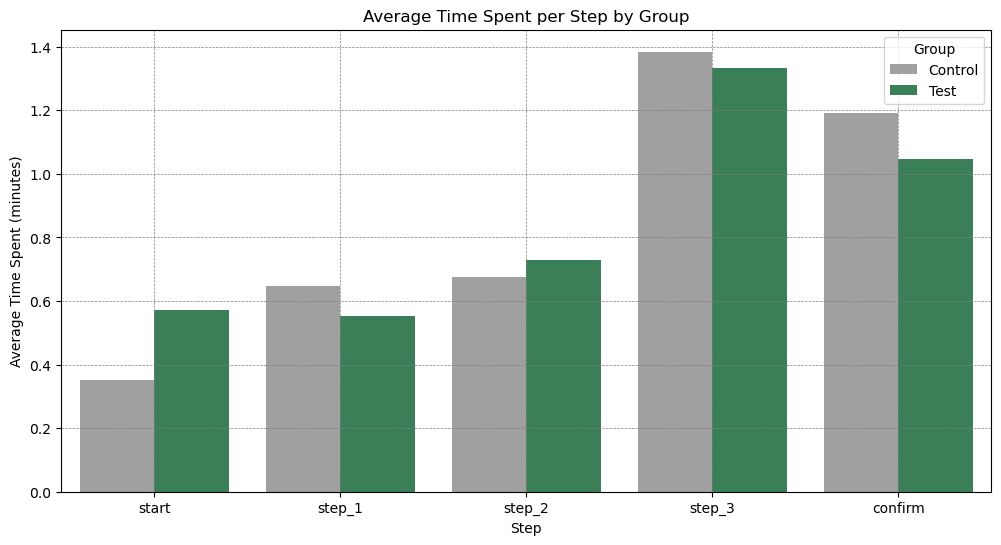

=== Pruebas Estadísticas por Paso ===
      step     t_stat       p_value
0  confirm -13.313949  2.879427e-40
1    start  18.958964  9.366436e-80
2   step_1 -10.972804  5.828826e-28
3   step_2   5.947904  2.748188e-09
4   step_3  -5.120889  3.064803e-07

Rechazamos H0 para el paso start (p < 0.05). Hay diferencia estadísticamente significativa en el tiempo promedio entre Test y Control.

Rechazamos H0 para el paso step_1 (p < 0.05). Hay diferencia estadísticamente significativa en el tiempo promedio entre Test y Control.

Rechazamos H0 para el paso step_2 (p < 0.05). Hay diferencia estadísticamente significativa en el tiempo promedio entre Test y Control.

Rechazamos H0 para el paso step_3 (p < 0.05). Hay diferencia estadísticamente significativa en el tiempo promedio entre Test y Control.

Rechazamos H0 para el paso confirm (p < 0.05). Hay diferencia estadísticamente significativa en el tiempo promedio entre Test y Control.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# --------------------------------------------------
# PASO 1: Cargar el DataFrame ya procesado
# --------------------------------------------------
df = pd.read_csv("../../data/processed/navegacion_clientes_experimento_limpio.csv")
df = df[df["variation"].isin(["Test", "Control"])].copy()

# --------------------------------------------------
# PASO 2: Convertir la columna date_time a tipo datetime
# --------------------------------------------------
df['date_time'] = pd.to_datetime(df['date_time'])

# --------------------------------------------------
# PASO 3: Ordenar el DataFrame por client_id y date_time
# --------------------------------------------------
df = df.sort_values(by=['client_id', 'date_time'])

# --------------------------------------------------
# PASO 4: Calcular el tiempo que cada usuario pasa en cada paso
# --------------------------------------------------
df['time_spent'] = df.groupby('client_id')['date_time'].diff().dt.total_seconds()
df['time_spent'] = df['time_spent'].fillna(0)

# Filtrar valores anómalos (por ejemplo, tiempos mayores a 1 día)
df = df[df['time_spent'] <= 86400]

# --------------------------------------------------
# PASO 5: Eliminar valores atípicos utilizando el método IQR
# --------------------------------------------------
Q1 = df['time_spent'].quantile(0.25)
Q3 = df['time_spent'].quantile(0.75)
IQR = Q3 - Q1
df = df[(df['time_spent'] >= (Q1 - 1.5 * IQR)) & (df['time_spent'] <= (Q3 + 1.5 * IQR))]

# --------------------------------------------------
# PASO 6: Agrupar por usuario y paso para calcular el tiempo total en cada paso
# --------------------------------------------------
step_data = df.groupby(['client_id', 'process_step', 'variation']).agg({'time_spent': 'sum'}).reset_index()

# --------------------------------------------------
# PASO 7: Calcular el tiempo promedio por paso para cada grupo (Test/Control)
# --------------------------------------------------
avg_time_per_step = step_data.groupby(['process_step', 'variation']).agg({'time_spent': 'mean'}).reset_index()

# Convertir el tiempo promedio de segundos a minutos
avg_time_per_step['time_spent'] = avg_time_per_step['time_spent'] / 60

# --------------------------------------------------
# PASO 8: Ordenar las categorías de process_step
# --------------------------------------------------
order = ['start', 'step_1', 'step_2', 'step_3', 'confirm']
avg_time_per_step['process_step'] = pd.Categorical(avg_time_per_step['process_step'], categories=order, ordered=True)
avg_time_per_step = avg_time_per_step.sort_values('process_step')

# --------------------------------------------------
# PASO 9: Visualizar los resultados
# --------------------------------------------------
plt.figure(figsize=(12, 6))
sns.barplot(
    x='process_step', 
    y='time_spent', 
    hue='variation', 
    data=avg_time_per_step, 
    palette={'Test': '#2E8B57', 'Control': '#A0A0A0'}  # Verde para Test, Gris para Control
)
plt.title('Average Time Spent per Step by Group')
plt.xlabel('Step')
plt.ylabel('Average Time Spent (minutes)')
plt.legend(title='Group')
plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray')

# Guardar la imagen en un archivo JPG
plt.savefig("../../img/cr_time_per_step.jpg", dpi=300, bbox_inches='tight')
plt.show()

# --------------------------------------------------
# PASO 10: Realizar pruebas estadísticas para cada paso
# --------------------------------------------------
results = []
for step in step_data['process_step'].unique():
    test_times = step_data[(step_data['process_step'] == step) & (step_data['variation'] == 'Test')]['time_spent']
    control_times = step_data[(step_data['process_step'] == step) & (step_data['variation'] == 'Control')]['time_spent']
    t_stat, p_value = stats.ttest_ind(test_times, control_times)
    results.append({'step': step, 't_stat': t_stat, 'p_value': p_value})

# Convertir los resultados a un DataFrame
results_df = pd.DataFrame(results)

# Mostrar los resultados
print("=== Pruebas Estadísticas por Paso ===")
print(results_df)

# --------------------------------------------------
# PASO 11: Conclusión
# --------------------------------------------------
for step in order:
    row = results_df[results_df['step'] == step].iloc[0]
    if row['p_value'] < 0.05:
        print(f"\nRechazamos H0 para el paso {row['step']} (p < 0.05). Hay diferencia estadísticamente significativa en el tiempo promedio entre Test y Control.")
    else:
        print(f"\nNo podemos rechazar H0 para el paso {row['step']} (p >= 0.05). No hay diferencia estadísticamente significativa en el tiempo promedio entre Test y Control.")
